In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

bc_data = datasets.load_breast_cancer()
df = pd.DataFrame(data= np.c_[bc_data['data'], bc_data['target']],
                     columns=list(bc_data['feature_names']) + ['target'])

X = df.values[:, :-1]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


pipeline = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA()),
    ('lr', LogisticRegression())])
pipeline.fit(X_train, y_train)

print('Test acc: {}'.format(pipeline.score(X_test, y_test)))


Test acc: 0.982456140351


In [7]:
kfold = StratifiedKFold(n_splits=10, random_state=1)

for k, (train, test) in enumerate(kfold.split(X_train, y_train)):
    pipeline.fit(X_train[train], y_train[train])
    print('Fold {}, class dist {}, score {}'.format(k, np.bincount(y_train[train]), 
                                                    pipeline.score(X_test[test], y_test[test])))
    

In [2]:
scores = cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=10, n_jobs=1)
print(scores)

[ 0.93478261  0.97826087  0.95652174  0.97826087  0.97826087  1.          1.
  0.97777778  0.97777778  0.97777778]


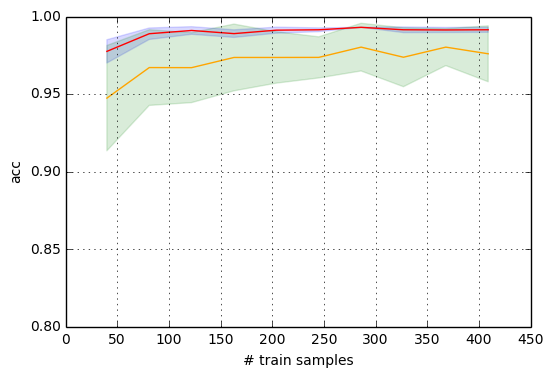

In [10]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', random_state=0))
])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='red', label='training acc')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='orange', label='validation acc')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('# train samples')
plt.ylabel('acc')
plt.ylim([0.8, 1.0])
plt.show()

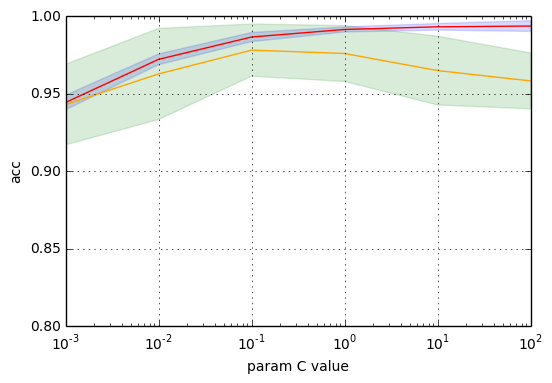

In [15]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='lr__C', 
                                             param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='red', label='training acc')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='orange', label='validation acc')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('param C value')
plt.ylabel('acc')
plt.xscale('log')
plt.ylim([0.8, 1.0])
plt.show()

In [12]:
pipe_lr.get_params().keys()

['scl',
 'scl__copy',
 'lr__solver',
 'lr__n_jobs',
 'lr__penalty',
 'lr__max_iter',
 'lr__random_state',
 'lr__multi_class',
 'lr__tol',
 'lr__dual',
 'lr__fit_intercept',
 'steps',
 'scl__with_mean',
 'lr__intercept_scaling',
 'lr__class_weight',
 'lr',
 'lr__warm_start',
 'lr__verbose',
 'lr__C',
 'scl__with_std']

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([
    ('slc', StandardScaler()),
    ('svc', SVC(random_state=1))
])

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']},
]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)



0.956043956044
{'svc__gamma': 0.01, 'svc__kernel': 'rbf', 'svc__C': 100}


In [23]:
est = gs.best_estimator_ 
est.fit(X_train, y_train)
print('test acc {}'.format(est.score(X_test, y_test)))

test acc 0.973684210526


In [24]:
# nested CV 

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('Nested 5x2 acc: {}'.format(np.mean(scores)))

Nested 5x2 acc: 0.962637362637


In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
roc = roc_auc_score(y_true=y_test, y_score=y_pred)

print(confmat)
print(recall)
print(f1)
print(roc)

[[40  2]
 [ 1 71]]
0.986111111111
0.979310344828
0.969246031746
